In [1]:
import tensorflow as tf
import numpy as np
from censai import PhysicalModel, RIMSharedUnet
from censai.models import SharedUnetModel
from censai.data.lenses_tng import decode_train, decode_physical_model_info
from censai.utils import nullwriter, rim_residual_plot as residual_plot, plot_to_image
import os, glob, time
from datetime import datetime
from tensorboard.plugins.hparams import api as hp
import random
""" # NOTE ON THE USE OF MULTIPLE GPUS #
Double the number of gpus will not speed up the code. In fact, doubling the number of gpus and mirroring 
the ops accross replicas means the code is TWICE as slow.

In fact, using multiple gpus means one should at least multiply the batch size by the number of gpus introduced, 
and optimize hyperparameters accordingly (learning rate should be scaled similarly).
"""
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) == 1:
    STRATEGY = tf.distribute.OneDeviceStrategy(device="/gpu:0")
elif len(gpus) > 1:
    STRATEGY = tf.distribute.MirroredStrategy()
from censai.utils import nullcontext
PHYSICAL_MODEL_DEVICE = nullcontext()
wndb = False


    
    
RIM_HPARAMS = [
    "adam",
    "steps",
    "kappalog",
    "kappa_normalize"
]
UNET_MODEL_HPARAMS = [
    "filters",
    "filter_scaling",
    "kernel_size",
    "layers",
    "block_conv_layers",
    "strides",
    "bottleneck_kernel_size"
    "bottleneck_filters",
    "resampling_kernel_size",
    "gru_kernel_size",
    "upsampling_interpolation",
    "kernel_regularizer_amp",
    "bias_regularizer_amp",
    "activation",
    "alpha",
    "initializer",
    "kappa_resize_filters",
    "kappa_resize_method",
    "kappa_resize_conv_layers",
    "kappa_resize_strides",
    "kappa_resize_kernel_size",
    "kappa_resize_separate_grad_downsampling"
]

In [2]:
def is_power_of_two(n):
    while n > 1:
        n /= 2
        if int(n) != n:
            return False
        elif n == 2:
            return True


def main(args):
    if wndb:
        config = wandb.config
        config.update(vars(args))
    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    random.shuffle(files)
    # Read concurrently from multiple records
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, num_parallel_reads=args.num_parallel_reads, compression_type=args.compression_type),
                               cycle_length=args.cycle_length, block_length=args.block_length)
    # Read off global parameters from first example in dataset
    for params in dataset.map(decode_physical_model_info):
        break
    dataset = dataset.map(decode_train).batch(args.batch_size)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file).prefetch(tf.data.experimental.AUTOTUNE)
    else:  # do not cache if no file is provided, dataset is huge and does not fit in GPU or RAM
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = dataset.take(int(args.train_split * args.total_items) // args.batch_size) # dont forget to divide by batch size!
    val_dataset = dataset.skip(int(args.train_split * args.total_items) // args.batch_size)
    val_dataset = val_dataset.take(int((1 - args.train_split) * args.total_items) // args.batch_size)
    train_dataset = STRATEGY.experimental_distribute_dataset(train_dataset)
    val_dataset = STRATEGY.experimental_distribute_dataset(val_dataset)
    if args.raytracer is not None:
        import json
        with open(os.path.join(args.raytracer, "ray_tracer_hparams.json"), "r") as f:
            raytracer_hparams = json.load(f)
    else:
        raytracer_hparams = {}
    with STRATEGY.scope():  # Replicate ops accross gpus
        phys = PhysicalModel(
            pixels=params["kappa pixels"].numpy(),
            src_pixels=params["src pixels"].numpy(),
            image_fov=params["image fov"].numpy(),
            kappa_fov=params["kappa fov"].numpy(),
            method=args.forward_method,
            noise_rms=params["noise rms"].numpy(),
            kappalog=args.kappalog,
            checkpoint_path=args.raytracer,
            device=PHYSICAL_MODEL_DEVICE,
            **raytracer_hparams
        )
        assert is_power_of_two(phys.pixels)
        assert is_power_of_two(phys.src_pixels)
        kappa_resize_layers = (phys.pixels // phys.src_pixels) // args.kappa_resize_strides
        vars(args).update({"kappa_resize_layers": kappa_resize_layers})
        if args.raytracer is not None:
            # load last checkpoint in the checkpoint directory
            checkpoint = tf.train.Checkpoint(net=phys.RayTracer)
            manager = tf.train.CheckpointManager(checkpoint, directory=args.raytracer, max_to_keep=3)
            checkpoint.restore(manager.latest_checkpoint)
        unet = SharedUnetModel(
            kappa_resize_layers=args.kappa_resize_layers,
            filters=args.filters,
            filter_scaling=args.filter_scaling,
            kernel_size=args.kernel_size,
            layers=args.layers,
            block_conv_layers=args.block_conv_layers,
            strides=args.strides,
            bottleneck_kernel_size=args.bottleneck_kernel_size,
            bottleneck_filters=args.bottleneck_filters,
            resampling_kernel_size=args.resampling_kernel_size,
            gru_kernel_size=args.gru_kernel_size,
            upsampling_interpolation=args.upsampling_interpolation,
            kernel_regularizer_amp=args.kernel_regularizer_amp,
            bias_regularizer_amp=args.bias_regularizer_amp,
            activation=args.activation,
            alpha=args.alpha,
            initializer=args.initializer,
            kappa_resize_filters=args.kappa_resize_filters,
            kappa_resize_strides=args.kappa_resize_strides,
            kappa_resize_conv_layers=args.kappa_resize_conv_layers,
            kappa_resize_kernel_size=args.kappa_resize_kernel_size,
            kappa_resize_method=args.kappa_resize_method,
            kappa_resize_separate_grad_downsampling=args.kappa_resize_separate_grad_downsampling
        )
        rim = RIMSharedUnet(
            physical_model=phys,
            unet=unet,
            steps=args.steps,
            adam=args.adam,
            kappalog=args.kappalog,
            kappa_normalize=args.kappa_normalize
        )
        learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=args.initial_learning_rate,
            decay_rate=args.decay_rate,
            decay_steps=args.decay_steps,
            staircase=args.staircase
        )
        optim = tf.optimizers.Adam(learning_rate=learning_rate_schedule)

    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id
    elif args.logname is not None:
        logname = args.logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y-%m-%d_%H-%M-%S")
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        traindir = os.path.join(logdir, "train")
        testdir = os.path.join(logdir, "test")
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        if not os.path.isdir(traindir):
            os.mkdir(traindir)
        if not os.path.isdir(testdir):
            os.mkdir(testdir)
        train_writer = tf.summary.create_file_writer(traindir)
        test_writer = tf.summary.create_file_writer(testdir)
    else:
        test_writer = nullwriter()
        train_writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            import json
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f)
            with open(os.path.join(checkpoints_dir, "unet_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in UNET_MODEL_HPARAMS}
                json.dump(hparams_dict, f)
            with open(os.path.join(checkpoints_dir, "rim_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)["rim_" + key] for key in RIM_HPARAMS}
                json.dump(hparams_dict, f)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.unet)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            if args.load_checkpoint == "lastest":
                checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
            elif args.load_checkpoint == "best":
                scores = np.loadtxt(os.path.join(checkpoints_dir, "score_sheet.txt"))
                _checkpoint = scores[np.argmin(scores[:, 1]), 0]
                checkpoint = checkpoint_manager.checkpoints[_checkpoint]
                checkpoint_manager.checkpoint.restore(checkpoint)
            else:
                checkpoint = checkpoint_manager.checkpoints[int(args.load_checkpoint)]
                checkpoint_manager.checkpoint.restore(checkpoint)
    else:
        save_checkpoint = False
    # =================================================================================================================

    def train_step(inputs):
        X, source, kappa = inputs
        with tf.GradientTape() as tape:
            tape.watch(rim.unet.trainable_variables)
            cost = rim.cost_function(X, source, kappa, reduction=False)
            cost = tf.reduce_sum(cost) / args.batch_size  # Reduce by the global batch size, not the replica batch size
        gradient = tape.gradient(cost, rim.unet.trainable_variables)
        if args.clipping:
            gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
        optim.apply_gradients(zip(gradient, rim.unet.trainable_variables))
        return cost

    @tf.function
    def distributed_train_step(dist_inputs):
        per_replica_losses = STRATEGY.run(train_step, args=(dist_inputs,))
        # Replica losses are aggregated by summing them
        return STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

    def test_step(inputs):
        X, source, kappa = inputs
        cost = rim.cost_function(X, source, kappa, reduction=False)
        cost = tf.reduce_sum(cost) / args.batch_size
        return cost

    @tf.function
    def distributed_test_step(dist_inputs):
        per_replica_losses = STRATEGY.run(test_step, args=(dist_inputs,))
        # Replica losses are aggregated by summing them
        return STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

    # ====== Training loop ============================================================================================
    epoch_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    best_loss = np.inf
    patience = args.patience
    step = 0
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        epoch_loss.reset_states()
        with train_writer.as_default():
            for batch, distributed_inputs in enumerate(train_dataset):
                start = time.time()
                cost = distributed_train_step(distributed_inputs)
                #========== Summary and logs ==========
                _time = time.time() - start
                tf.summary.scalar("Time per step", _time, step=step)
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                tf.summary.scalar("MSE", cost, step=step)
                step += 1
            tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
            # last batch we make a summary of residuals
            # last batch we make a summary of residuals
            for res_idx in range(min(args.n_residuals, args.batch_size)):
                lens_true = distributed_inputs[0][res_idx, ...]
                source_true = distributed_inputs[1][res_idx, ...]
                kappa_true = distributed_inputs[2][res_idx, ...]
                source_pred, kappa_pred, chi_squared = rim.call(lens_true[None, ...])
                lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])[0, ...]
                tf.summary.image(f"Residual {res_idx}",
                                 plot_to_image(
                                     residual_plot(
                                         lens_true, source_true, rim.kappa_link(kappa_true), lens_pred, source_pred[-1][0, ...],
                                         kappa_pred[-1][0, ...], chi_squared
                                     )), step=step)
#         with test_writer.as_default():
#             val_loss.reset_states()
#             for distributed_inputs in val_dataset:
#                 test_cost = distributed_test_step(distributed_inputs)
#                 val_loss.update_state([test_cost])
#             for res_idx in range(min(args.n_residuals, args.batch_size)):
#                 lens_true = distributed_inputs[0][res_idx, ...]
#                 source_true = distributed_inputs[1][res_idx, ...]
#                 kappa_true = distributed_inputs[2][res_idx, ...]
#                 source_pred, kappa_pred, chi_squared = rim.call(lens_true[None, ...])
#                 lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])[0, ...]
#                 tf.summary.image(f"Residual {res_idx}",
#                                  plot_to_image(
#                                      residual_plot(
#                                          lens_true, source_true, rim.kappa_link(kappa_true), lens_pred, source_pred[-1][0, ...],
#                                          kappa_pred[-1][0, ...], chi_squared
#                                      )), step=step)
#         val_cost = val_loss.result().numpy()
        train_cost = epoch_loss.result().numpy()
        val_cost = train_cost 
        print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} "
              f"| learning rate {optim.lr(step).numpy():.2e} | time per step {time_per_step.result().numpy():.2e} s")
        if val_cost < (1 - args.tolerance) * best_loss:
            best_loss = val_cost
            patience = args.patience
        else:
            patience -= 1
        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, val_cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
#     with tf.summary.create_file_writer(os.path.join(args.logdir, args.logname_prefixe + "_rim_hparams")).as_default():
#         hparams_dict = {key: vars(args)[key] for key in RIM_HPARAMS}
#         hp.hparams(hparams_dict)
#         tf.summary.scalar("Test MSE", best_loss, step=step)
#         tf.summary.scalar("Final Train MSE", train_cost, step=step)

#     with tf.summary.create_file_writer(os.path.join(args.logdir, args.logname_prefixe + "_unet_hparams")).as_default():
#         hparams_dict = {key: vars(args)[key] for key in UNET_MODEL_HPARAMS}
#         hp.hparams(hparams_dict)
#         tf.summary.scalar("Test MSE", best_loss, step=step)
#         tf.summary.scalar("Final Train MSE", train_cost, step=step)
    return rim, phys, train_dataset, val_dataset



In [7]:
from argparse import ArgumentParser
import json
parser = ArgumentParser()
parser.add_argument("--model_id",               default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--load_checkpoint",        default="best",                 help="One of 'best', 'lastest' or the specific checkpoint index.")
parser.add_argument("--datasets",               required=True,  nargs="+",      help="Path to directories that contains tfrecords of dataset. Can be multiple inputs (space separated)")
parser.add_argument("--compression_type",       default=None,                   help="Compression type used to write data. Default assumes no compression.")

# RIM hyperparameters
parser.add_argument("--steps",              default=16,     type=int,       help="Number of time steps of RIM")
parser.add_argument("--adam",               action="store_true",            help="ADAM update for the log-likelihood gradient.")
parser.add_argument("--kappalog",           action="store_true")
parser.add_argument("--kappa_normalize",    action="store_true")

# Shared Unet params
parser.add_argument("--filters",                                    default=32,     type=int)
parser.add_argument("--filter_scaling",                             default=1,      type=int)
parser.add_argument("--kernel_size",                                default=3,      type=int)
parser.add_argument("--layers",                                     default=2,      type=int)
parser.add_argument("--block_conv_layers",                          default=2,      type=int)
parser.add_argument("--strides",                                    default=2,      type=int)
parser.add_argument("--bottleneck_kernel_size",                     default=None,   type=int)
parser.add_argument("--bottleneck_filters",                         default=None,   type=int)
parser.add_argument("--resampling_kernel_size",                     default=None,   type=int)
parser.add_argument("--gru_kernel_size",                            default=None,   type=int)
parser.add_argument("--upsampling_interpolation",                   action="store_true")
parser.add_argument("--kernel_regularizer_amp",                     default=1e-4,   type=float)
parser.add_argument("--bias_regularizer_amp",                       default=1e-4,   type=float)
parser.add_argument("--activation",                                 default="leaky_relu")
parser.add_argument("--alpha",                                      default=0.1,    type=float)
parser.add_argument("--initializer",                                default="glorot_normal")
parser.add_argument("--kappa_resize_filters",                       default=4,      type=int)
parser.add_argument("--kappa_resize_method",                        default="bilinear")
parser.add_argument("--kappa_resize_conv_layers",                   default=1,      type=int)
parser.add_argument("--kappa_resize_strides",                       default=2,      type=int)
parser.add_argument("--kappa_resize_kernel_size",                   default=3,      type=int)
parser.add_argument("--kappa_resize_separate_grad_downsampling",    action="store_true")

# Physical model hyperparameter
parser.add_argument("--forward_method",         default="conv2d",               help="One of ['conv2d', 'fft', 'unet']. If the option 'unet' is chosen, the parameter "
                                                                                     "'--raytracer' must be provided and point to model checkpoint directory.")
parser.add_argument("--raytracer",              default=None,                   help="Path to raytracer checkpoint dir if method 'unet' is used.")

# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--train_split",            default=0.8,    type=float,     help="Fraction of the training set.")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--num_parallel_reads",     default=10,     type=int,       help="TFRecord dataset number of parallel reads when loading data.")
parser.add_argument("--cache_file",             default=None,                   help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--cycle_length",           default=4,      type=int,       help="Number of files to read concurrently.")
parser.add_argument("--block_length",           default=1,      type=int,       help="Number of example to read from each files.")

# Optimization params
parser.add_argument("-e", "--epochs",           default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--initial_learning_rate",  default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",             default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",            default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--staircase",              action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",               action="store_true",                  help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",               default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",              default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")

# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--logname_prefixe",         default="RIMUnet512",          help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each {%} iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")
parser.add_argument("--n_residuals",             default=1,     type=int,       help="Number of residual plots to save. Add overhead at the end of an epoch only.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None,                   help="A json filepath that will override every command line parameters. "
                                                                                     "Useful for reproducibility")

_StoreAction(option_strings=['--json_override'], dest='json_override', nargs=None, const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [13]:
import sys
sys.argv = ['']
args = parser.parse_args(
 f"--datasets {os.getenv('HOME')}/scratch/Censai/data/lenses128_NIS "\
  f"--compression_type=GZIP "\
  f"--forward_method=conv2d "\
  f"--epochs=400 "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=0.95 "\
  f"--decay_steps=50 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=40 "\
  f"--tolerance=0.01 "\
  f"--batch_size=1 "\
  f"--train_split=1 "\
  f"--total_items=1 "\
  f"--num_parallel_reads=1 "\
  f"--cycle_length=1 "\
  f"--block_length=1 "\
  f"--steps=16 "\
  f"--adam "\
  f"--kappalog "\
  f"--filters=32 "\
  f"--filter_scaling=1 "\
  f"--kernel_size=3 "\
  f"--layers=3 "\
  f"--block_conv_layers=2 "\
  f"--kernel_size=3 "\
  f"--resampling_kernel_size=5 "\
  f"--gru_kernel_size=5 "\
  f"--kernel_regularizer_amp=1e-4 "\
  f"--bias_regularizer_amp=1e-4 "\
  f"--alpha=0.1 "\
  f"--kappa_resize_filters=8 "\
  f"--kappa_resize_method=bilinear "\
  f"--kappa_resize_conv_layers=1 "\
  f"--kappa_resize_kernel_size=7 "\
  f"--kappa_resize_separate_grad_downsampling "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RIM_SharedUnet128_NIS_Interactive "\
#   f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
#   f"--checkpoints=5 "\
#   f"--max_to_keep=10 "\
  f"--n_residuals=0".split()

)

cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
rim, phys, train_dataset, val_dataset = main(args)

epoch 0 | train loss 6.572e-02 | val loss 6.572e-02 | learning rate 1.00e-04 | time per step 4.30e+01 s
epoch 1 | train loss 8.552e-02 | val loss 8.552e-02 | learning rate 1.00e-04 | time per step 2.19e+01 s
epoch 2 | train loss 5.844e-02 | val loss 5.844e-02 | learning rate 1.00e-04 | time per step 1.48e+01 s
epoch 3 | train loss 5.941e-02 | val loss 5.941e-02 | learning rate 1.00e-04 | time per step 1.13e+01 s
epoch 4 | train loss 5.984e-02 | val loss 5.984e-02 | learning rate 1.00e-04 | time per step 9.23e+00 s
epoch 5 | train loss 6.017e-02 | val loss 6.017e-02 | learning rate 1.00e-04 | time per step 7.82e+00 s
epoch 6 | train loss 5.785e-02 | val loss 5.785e-02 | learning rate 1.00e-04 | time per step 6.81e+00 s
epoch 7 | train loss 5.500e-02 | val loss 5.500e-02 | learning rate 1.00e-04 | time per step 6.06e+00 s
epoch 8 | train loss 5.588e-02 | val loss 5.588e-02 | learning rate 1.00e-04 | time per step 5.47e+00 s
epoch 9 | train loss 5.550e-02 | val loss 5.550e-02 | learning r

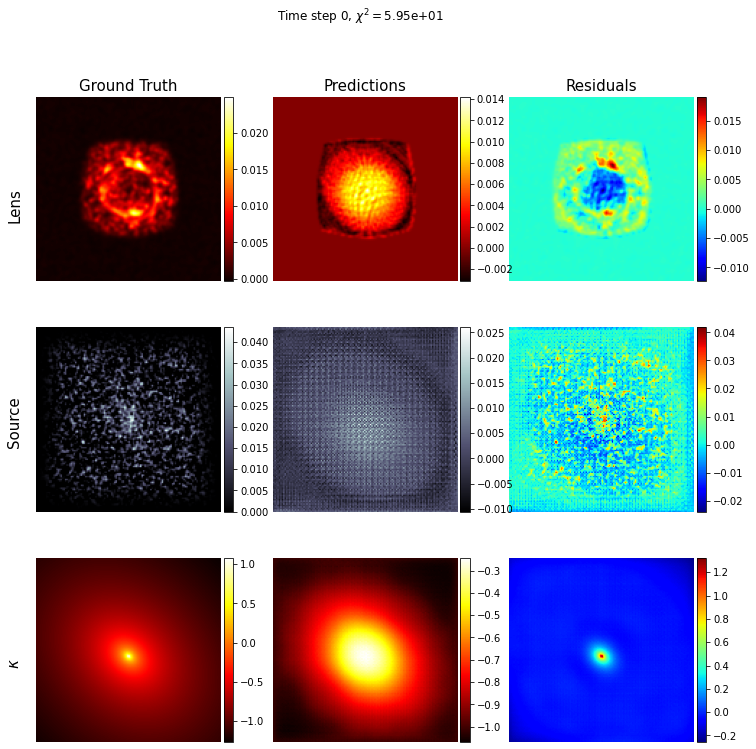

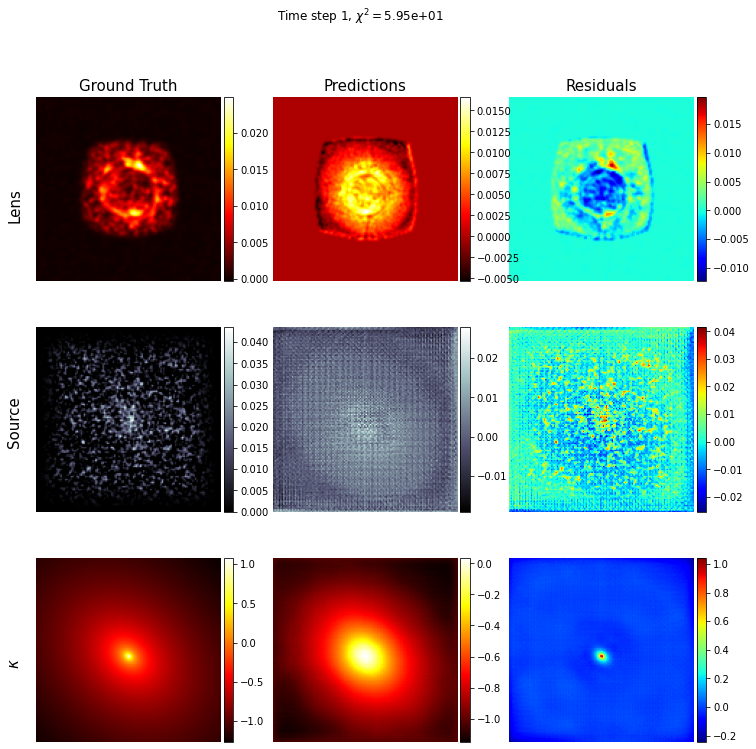

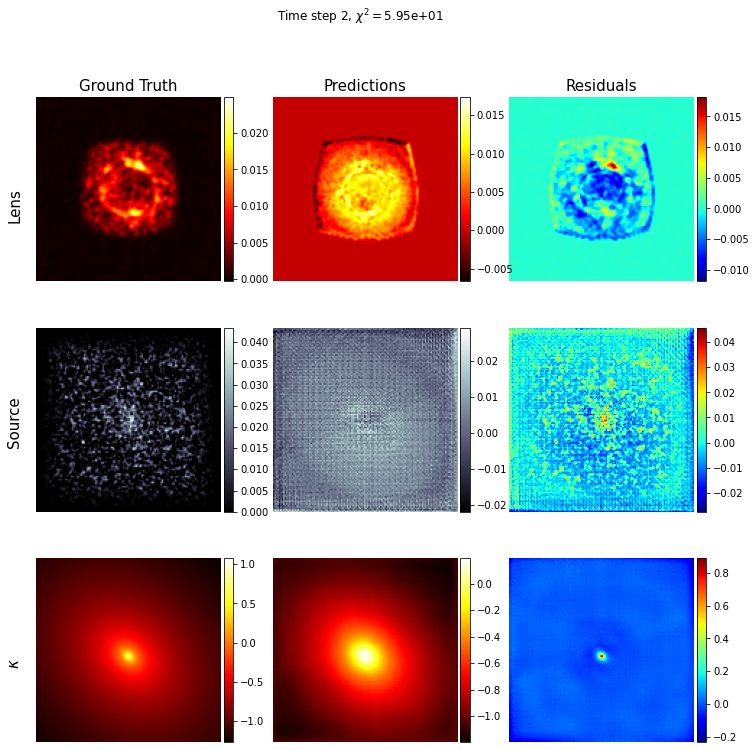

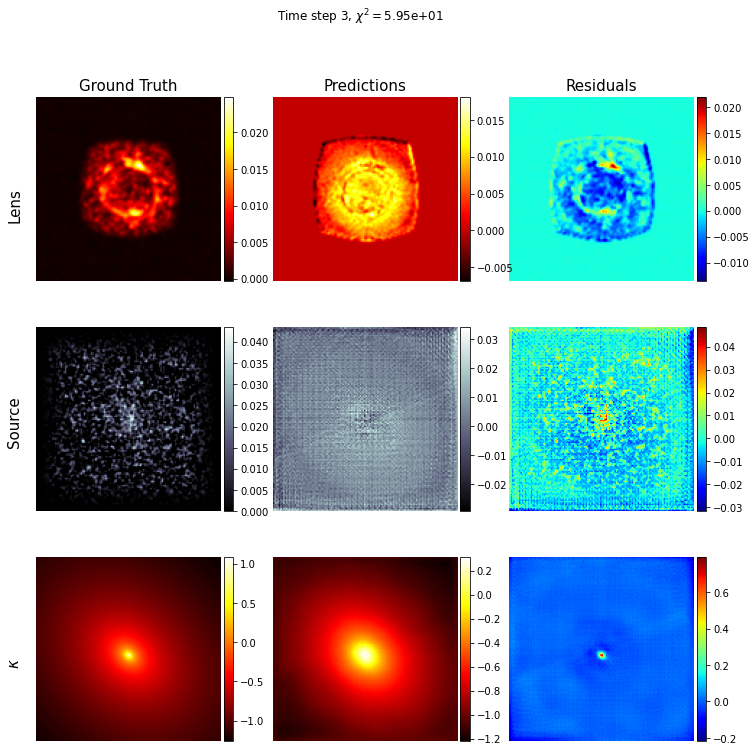

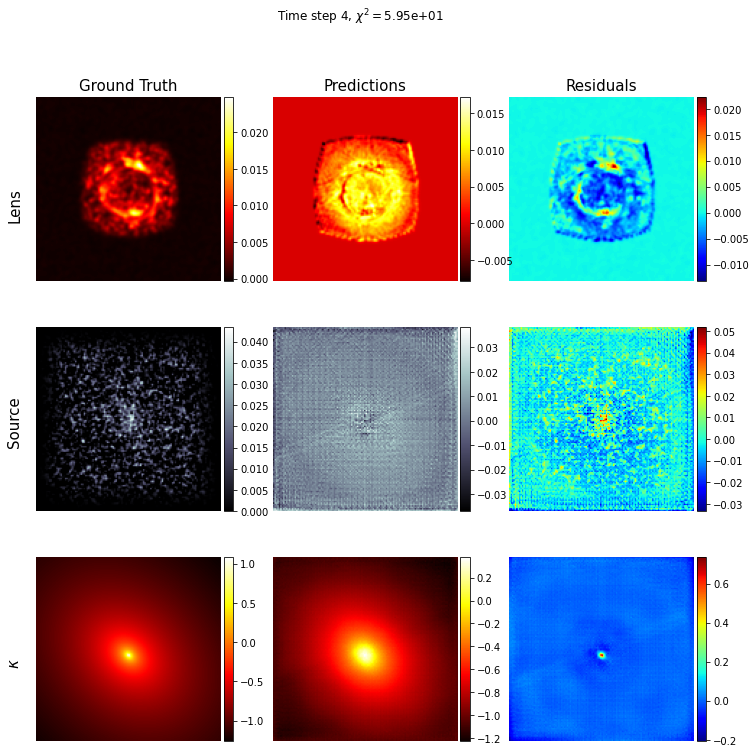

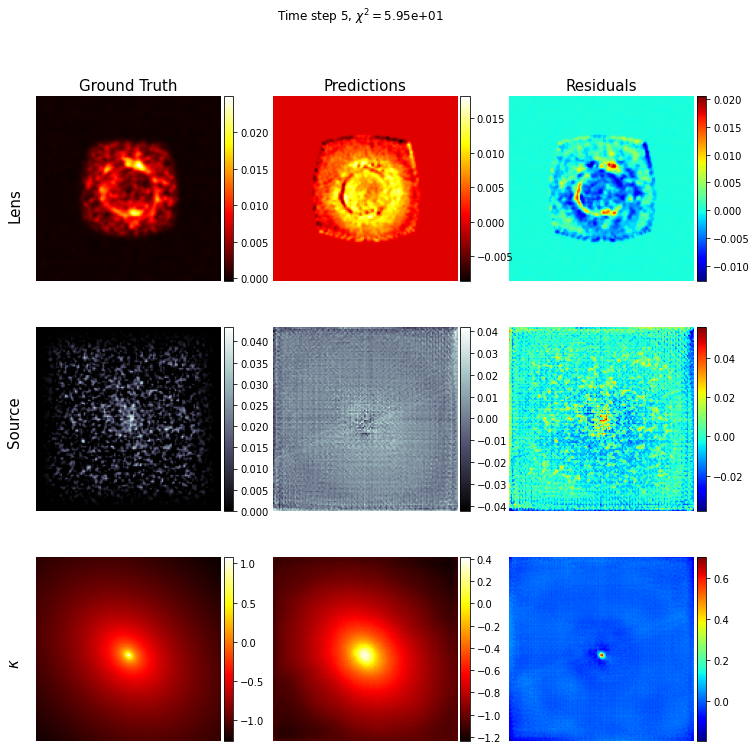

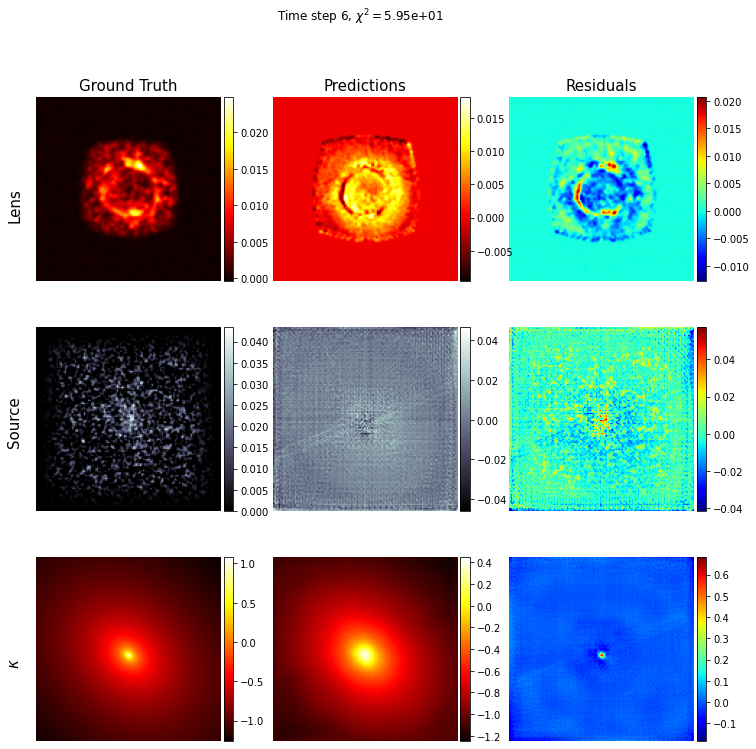

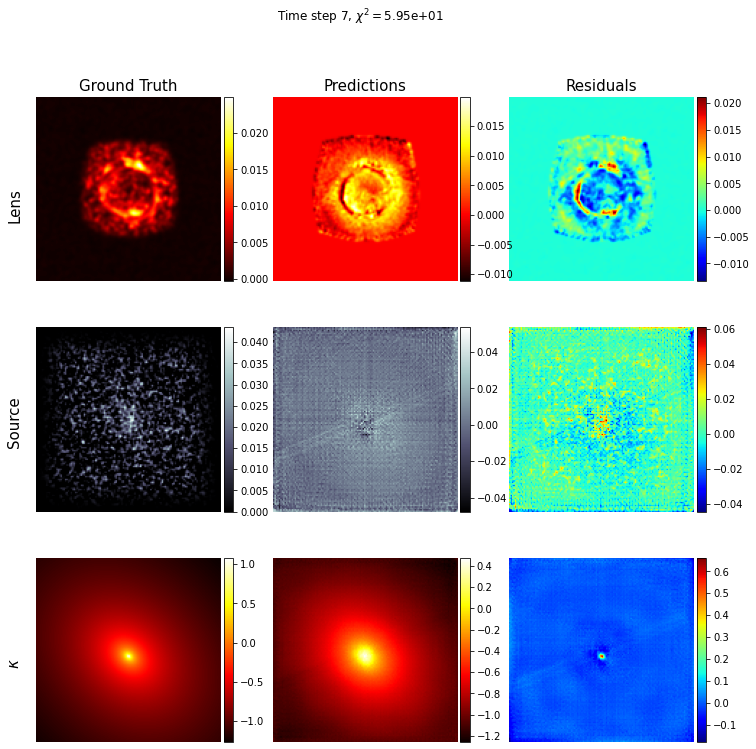

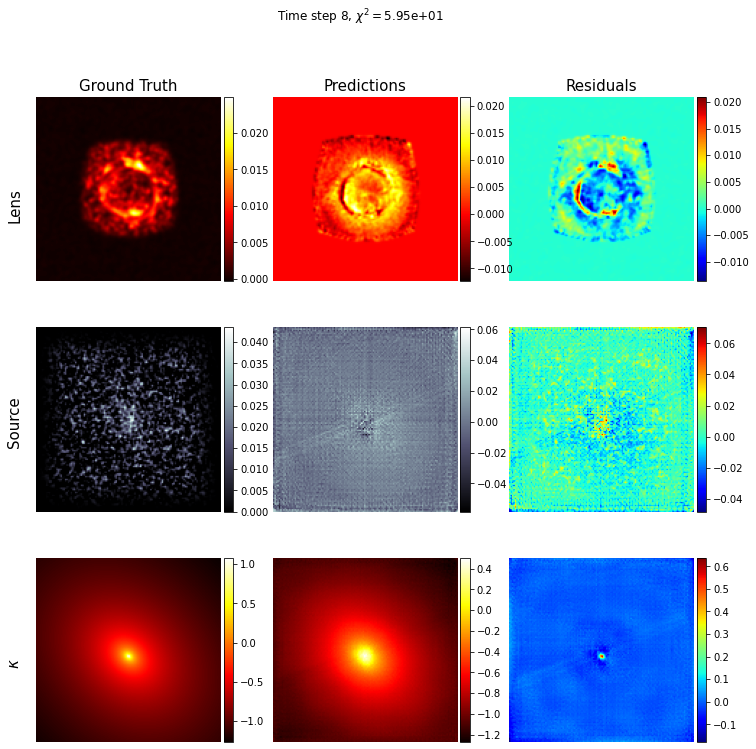

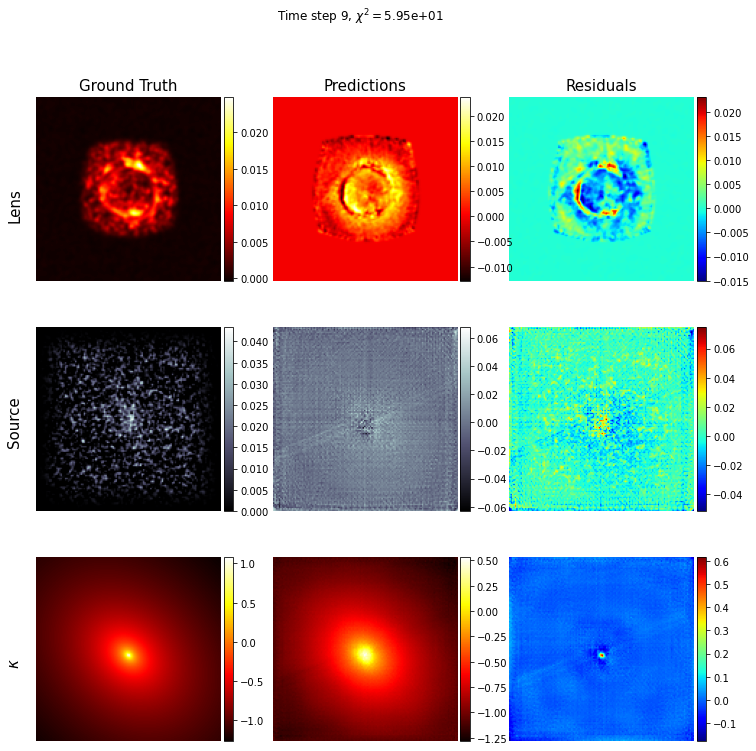

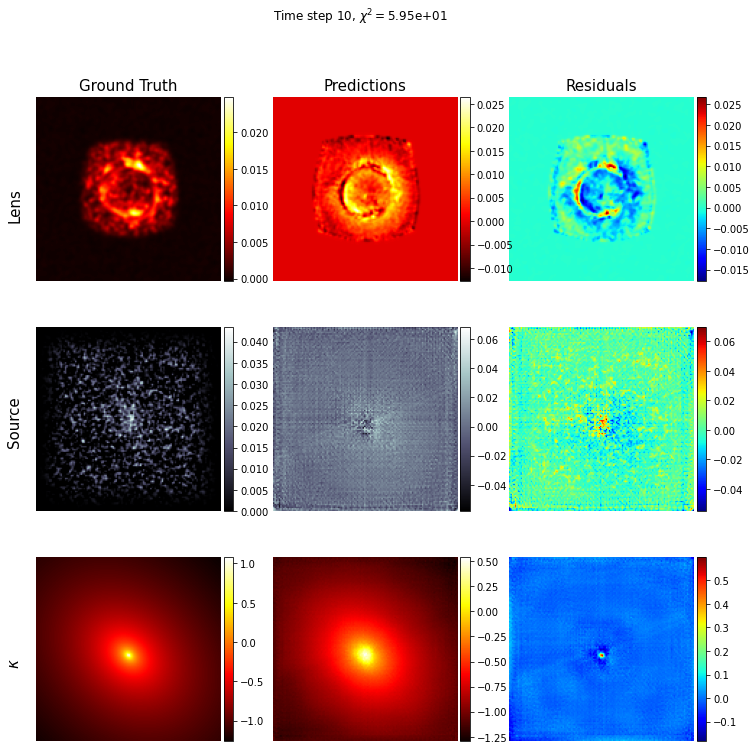

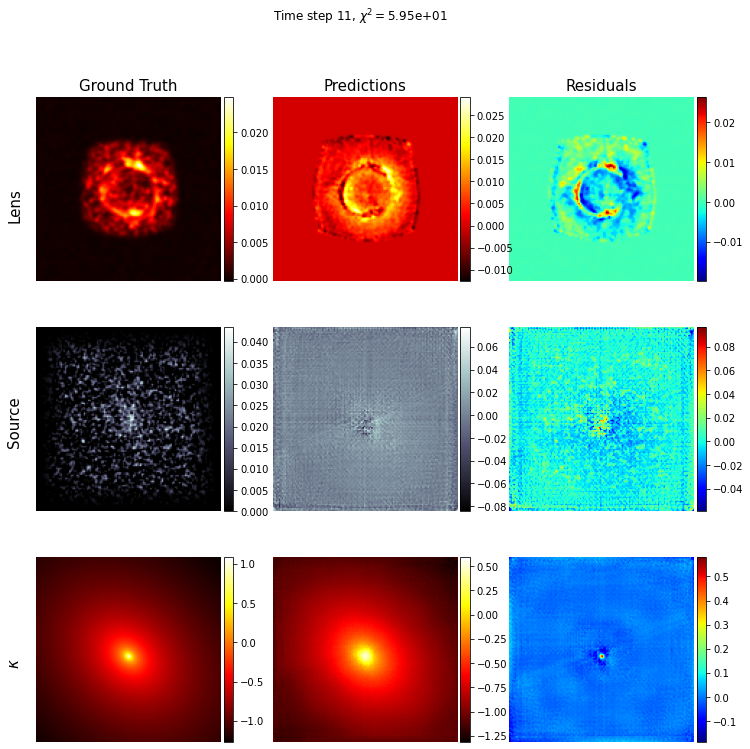

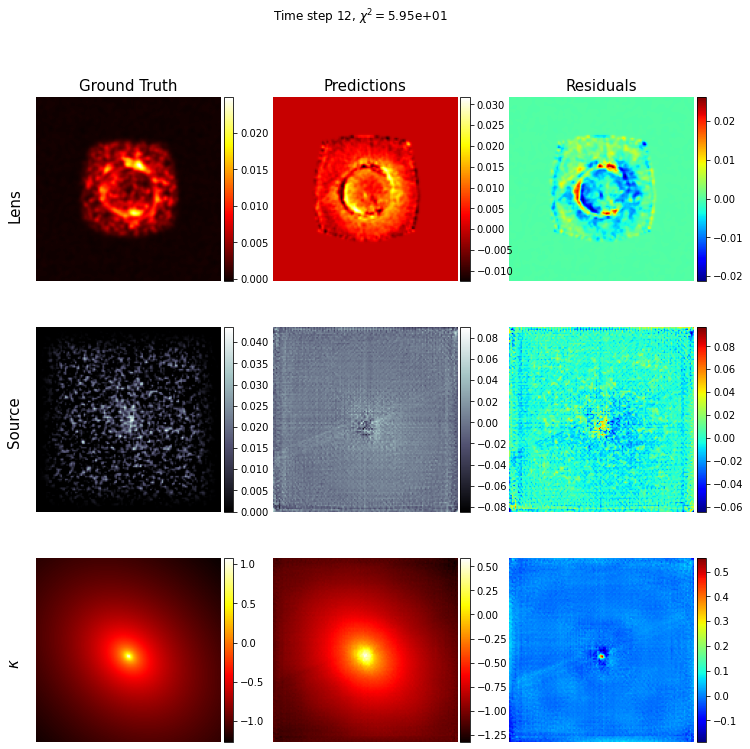

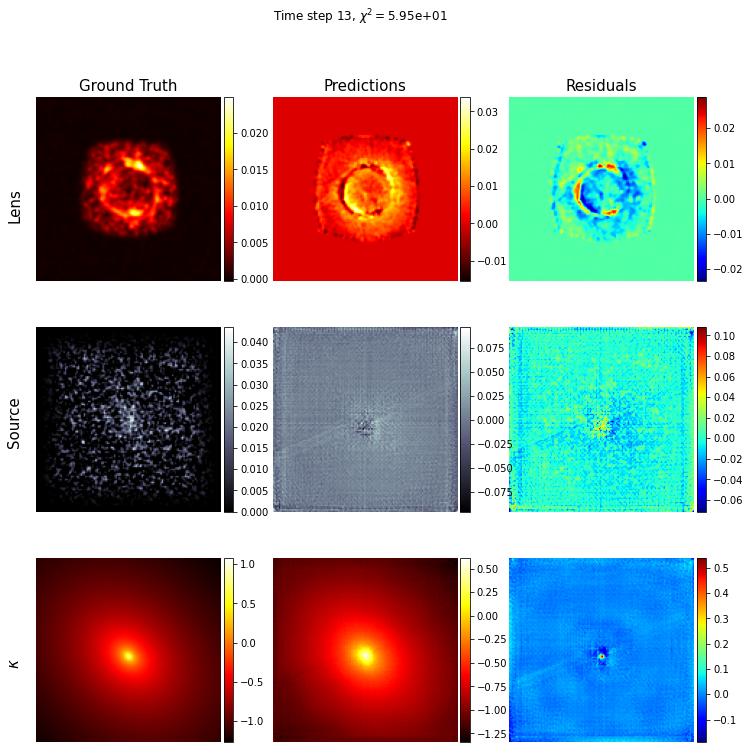

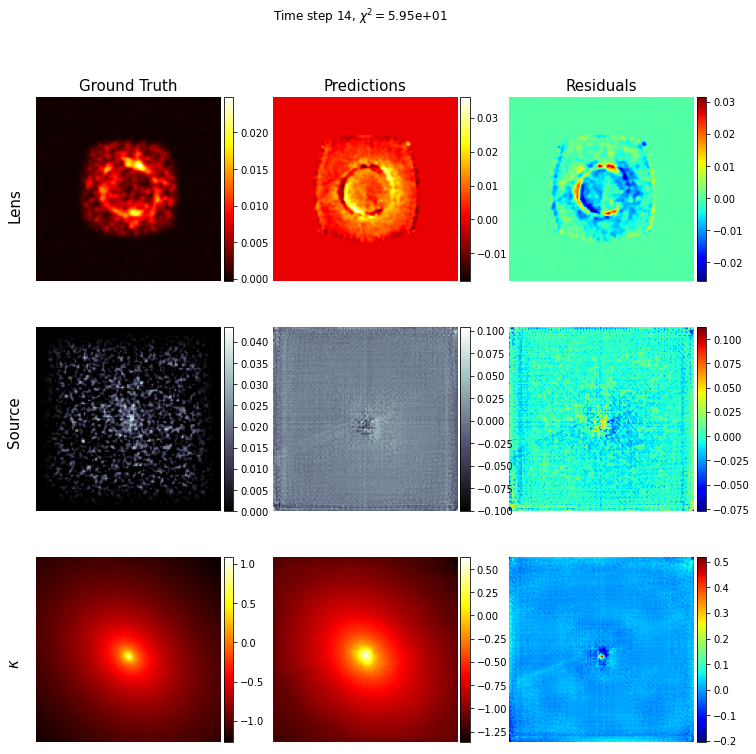

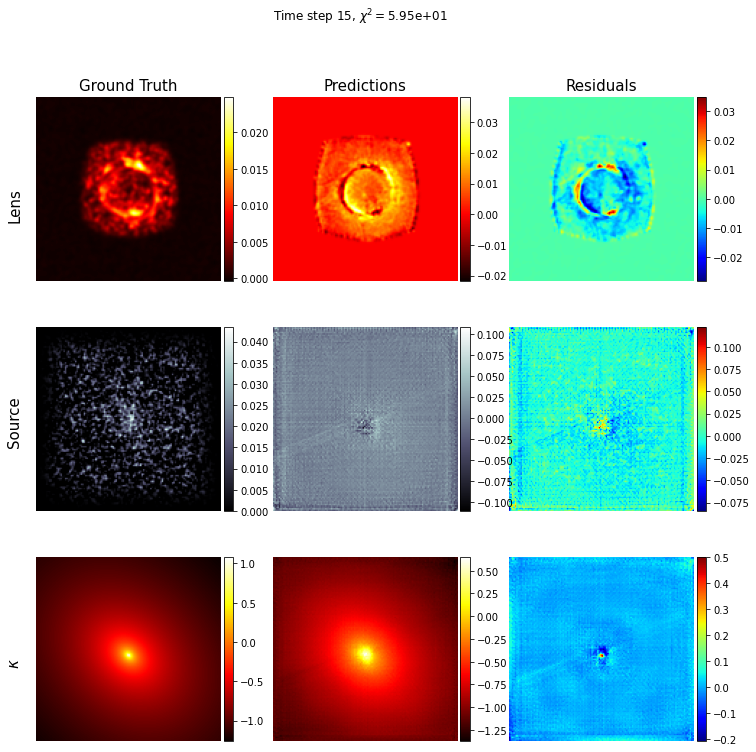

In [15]:
for batch, distributed_inputs in enumerate(train_dataset):
#     if batch < 4:
#         continue
    for res_idx in range(args.batch_size):
        for t in range(args.steps):
            lens_true = distributed_inputs[0][res_idx, ...]
            source_true = distributed_inputs[1][res_idx, ...]
            kappa_true = distributed_inputs[2][res_idx, ...]
            source_pred, kappa_pred, chi_squared = rim.call(lens_true[None, ...])
            lens_pred = phys.forward(source_pred[t], kappa_pred[t])[0, ...]
            fig = residual_plot(lens_true, source_true, rim.kappa_link(kappa_true), lens_pred, source_pred[t][0, ...], kappa_pred[t][0, ...], chi_squared)
            fig.suptitle(fr"Time step {t}, $\chi^2 = ${chi_squared:.2e}")
    break